In [4]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd
from keras import utils as np_utils

In [5]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
... resuming from 479199232 bytes (3989371709 bytes left) ...
100% 4.16G/4.16G [03:04<00:00, 17.0MB/s]
100% 4.16G/4.16G [03:04<00:00, 21.7MB/s]


In [6]:
# Unzip dataset
path_to_zip_file = "brats20-dataset-training-validation.zip"
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall("brats20-dataset-training-validation")

In [7]:
# Absolute path of the incorrectly named file
old_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_355/BraTS20_Training_355_seg.nii"

try:
    os.rename(old_name, new_name)
    print("The file has been successfully renamed")
except FileNotFoundError:
    print("Maybe you have already renamed the file or the file is not misspelled on the dataset anymore")

The file has been successfully renamed


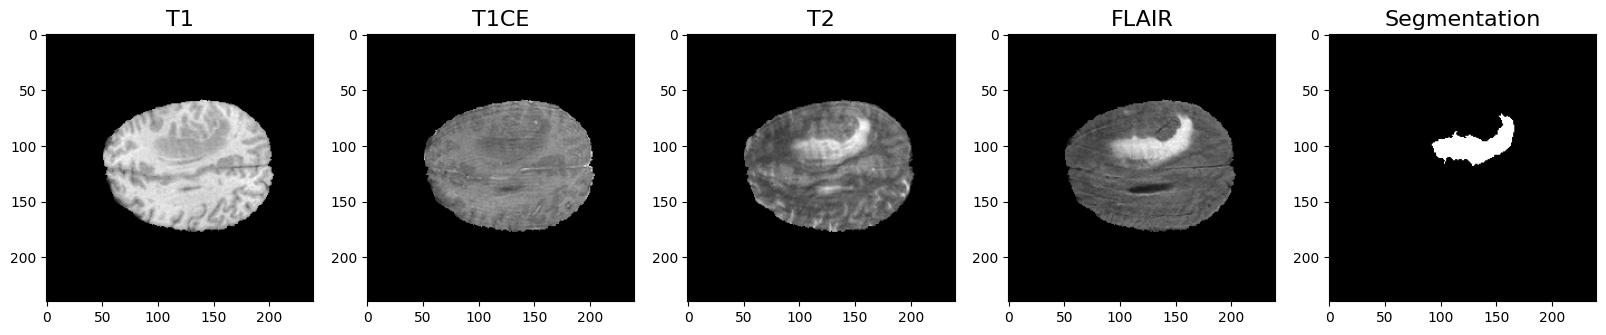

In [36]:
# Specify a sample path (here we will take the first patient of the Training dataset)
sample_path = 'brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'

# Load the 4 MRI modalities and the segmentation located in the patient's path using the nibabel library
t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')

# Get the image data
t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# Plot the 100th slice of the 4 RMI modalities and the segmentation
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs[0].set_title('T1', fontsize=16)
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="gray")
axs[1].set_title('T1CE',fontsize=16)
axs[2].imshow(t2_data[:,:,slice_nb], cmap="gray")
axs[2].set_title('T2',fontsize=16)
axs[3].imshow(flair_data[:,:,slice_nb], cmap="gray")
axs[3].set_title('FLAIR',fontsize=16)
axs[4].imshow(seg_data[:,:,slice_nb], cmap="gray")
axs[4].set_title('Segmentation',fontsize=16)
plt.show()

In [9]:
# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


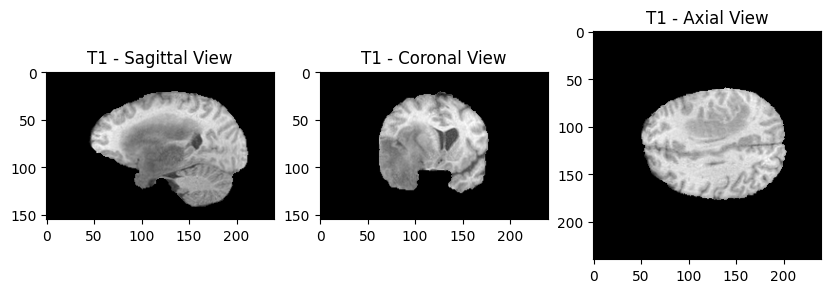

In [10]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="gray")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="gray")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

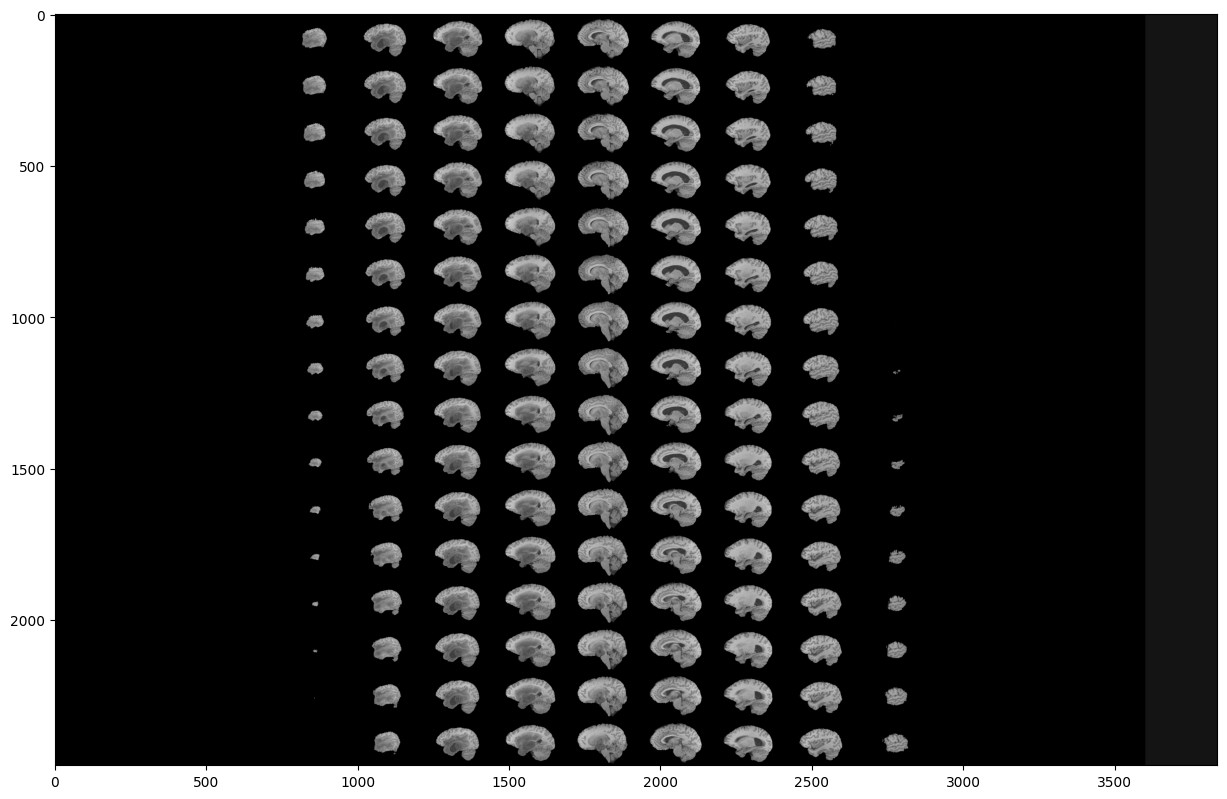

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[:,:,:]), 90, resize=True), cmap ='gray')

# montage allows us to concatenate multiple images of the same size horizontally and vertically

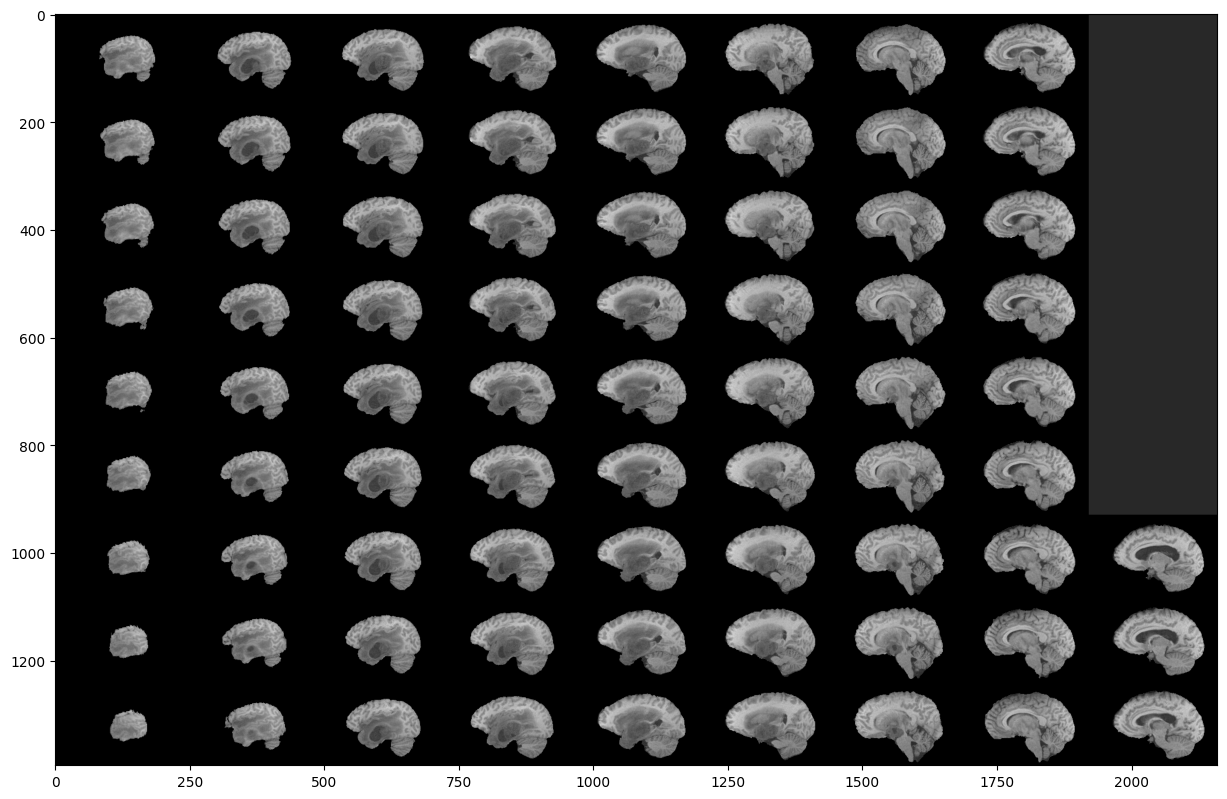

In [12]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(t1_data[60:135,:,:]), 90, resize=True), cmap ='gray')


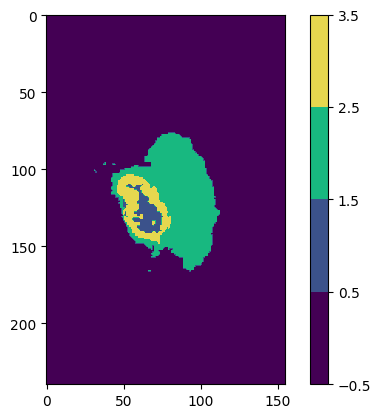

In [13]:
# Plot a segmantation
some_seg_img = nib.load("brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii").get_fdata()

cmap = mpl.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

plt.imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
plt.colorbar()

In [14]:
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
seg_samples = [os.path.join(data_path, sample, f"{sample}_seg.nii") for sample in os.listdir(data_path) if not sample.endswith('.csv')]

saved_values = []
max_nb_values = 0
for sample in seg_samples:
    seg_img = nib.load(sample).get_fdata()
    unique_values = np.unique(seg_img)
    nb_unique_values = len(np.unique(seg_img))

    if nb_unique_values > max_nb_values:
        max_nb_values = nb_unique_values
        saved_values = unique_values

print(f"Maximum number of values in all segmentation images: {max_nb_values}")
print(f"Values: {saved_values}")

Maximum number of values in all segmentation images: 4
Values: [0. 1. 2. 4.]


In [15]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(counts)

[8716021   15443  168794   27742]


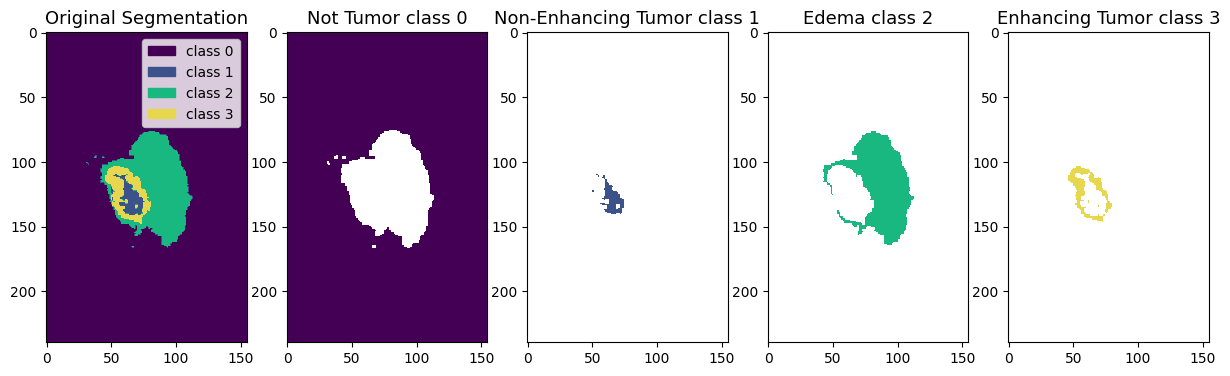

In [40]:
# Deletion of class 0
seg_0 = some_seg_img.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = some_seg_img.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = some_seg_img.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_3 = some_seg_img.copy()
seg_3[seg_3 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 3']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, axs3 = plt.subplots(1, 5, figsize=(15, 15))

axs3[0].imshow(some_seg_img[100,:,:], cmap=cmap, norm=norm)
axs3[0].set_title('Original Segmentation',fontsize=13)
axs3[0].legend(handles=legend, loc='upper right')

axs3[1].imshow(seg_0[100,:,:], cmap=cmap, norm=norm)
axs3[1].set_title('Not Tumor class 0',fontsize=13)

axs3[2].imshow(seg_1[100,:,:], cmap=cmap, norm=norm)
axs3[2].set_title('Non-Enhancing Tumor class 1',fontsize=13)

axs3[3].imshow(seg_2[100,:,:], cmap=cmap, norm=norm)
axs3[3].set_title('Edema class 2',fontsize=13)

axs3[4].imshow(seg_3[100,:,:], cmap=cmap, norm=norm)
axs3[4].set_title('Enhancing Tumor class 3',fontsize=13)

plt.show()

In [17]:
# Define selected slices range
VOLUME_START_AT = 60
VOLUME_SLICES = 75

In [18]:
# Specify path of our BraTS2020 directory
data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


In [19]:
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

In [20]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.2, random_state=42)

# Split the train set into the real train set and in a test set
samples_train, samples_test = train_test_split(samples_train, test_size=0.15, random_state=42)

# Print data distribution (Train: 68%, Test: 12%, Val: 20%)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 250
Validation length: 74
Test length: 45


In [21]:
IMG_SIZE = 128
class DataGenerator(np_utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        for c, i in enumerate(Batch_ids):

            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'

            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()

            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]
        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X/np.max(X), Y

training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)

In [22]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

In [23]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = tf.reshape(y_true, [-1]) # Flatten the tensors for all classes at once
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)     # Compute intersection and union using TensorFlow functions
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return dice

def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

In [24]:
input_layer = Input((IMG_SIZE, IMG_SIZE, 2)) #Define input data shape

model = build_unet(input_layer, 'he_normal', 0.2)  #Build and compile the model

model.compile(loss="categorical_crossentropy", optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tensorflow.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity] )

In [25]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

    keras.callbacks.ModelCheckpoint(filepath = 'model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
                             verbose=1, save_best_only=True, save_weights_only = True),

    CSVLogger('training.log', separator=',', append=False)
]

In [26]:
model.fit(training_generator,
          epochs=30,
          steps_per_epoch=len(samples_train),
          callbacks=callbacks,
          validation_data=valid_generator)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - accuracy: 0.9686 - dice_coef: 0.9074 - loss: 0.6846 - mean_io_u: 0.4708 - precision: 0.9566 - sensitivity: 0.9120 - specificity: 0.9945
Epoch 1: val_loss improved from inf to 0.10212, saving model to model_.01-0.102124.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 231s 695ms/step - accuracy: 0.9687 - dice_coef: 0.9076 - loss: 0.6827 - mean_io_u: 0.4709 - precision: 0.9566 - sensitivity: 0.9122 - specificity: 0.9945 - val_accuracy: 0.9795 - val_dice_coef: 0.9306 - val_loss: 0.1021 - val_mean_io_u: 0.2501 - val_precision: 0.9794 - val_sensitivity: 0.9772 - val_specificity: 0.9932 - learning_rate: 0.0010
Epoch 2/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.10212 to 0.10212, saving model to model_.02-0.102124.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 26s 105ms/step - accuracy: 0.0000e+00 - dice_coef: 0.0000e+00 - loss: 0.0000e+00 - mean_io_u: 0.0000e+00 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.0000e+00 - val_accuracy: 0.9795 - val_dice_coef: 0.9306 - val_loss: 0.1021 - val_mean_io_u: 0.2501 - val_precision: 0.9794 - val_sensitivity: 0.9772 - val_specificity: 0.9932 - learning_rate: 0.0010
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9818 - dice_coef: 0.9635 - loss: 0.0785 - mean_io_u: 0.4916 - precision: 0.9817 - sensitivity: 0.9802 - specificity: 0.9939
Epoch 3: val_loss improved from 0.10212 to 0.07494, saving model to model_.03-0.074941.weights.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 147s 573ms/step - accuracy: 0.9818 - dice_coef: 0.9635 - loss: 0.0785 - mean_io_u: 0.4917 - precision: 0.9817 - sensitivity: 0.9802 - specificity: 0.9939 - val_accuracy: 0.9795 - val

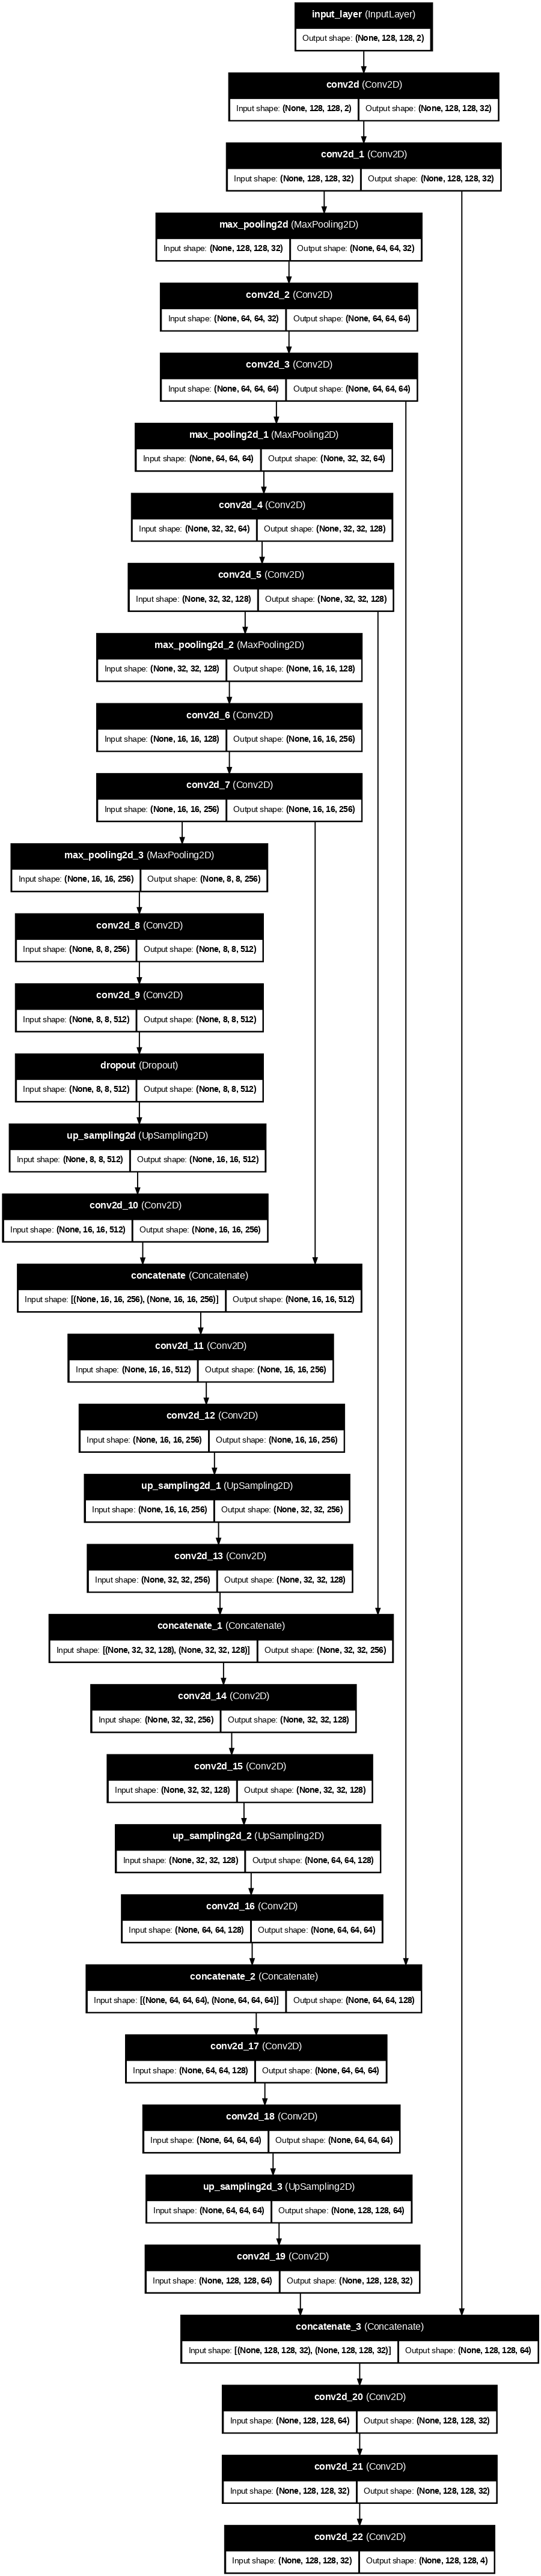

In [27]:
from tensorflow.keras.utils import plot_model

plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70)

In [28]:
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)

descriptions = ["Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision", "Sensitivity", "Specificity"]

# Combine results list and descriptions list
results_list = zip(results, descriptions)

# Display each metric with its description
print("\nModel evaluation on the test set:")
print("==================================")
for i, (metric, description) in enumerate(results_list):
    print(f"{description} : {round(metric, 4)}")

45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - accuracy: 0.9908 - dice_coef: 0.9867 - loss: 0.0264 - mean_io_u: 0.6720 - precision: 0.9926 - sensitivity: 0.9882 - specificity: 0.9975

Model evaluation on the test set:
Loss : 0.0329
Accuracy : 0.9894
MeanIOU : 0.5166
Dice coefficient : 0.9856
Precision : 0.9911
Sensitivity : 0.9869
Specificity : 0.997


In [29]:
model.save("Brain_tumor_segmentation_model.keras")

In [32]:
model = keras.models.load_model('/content/Brain_tumor_segmentation_model.keras',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                  }, compile=False)

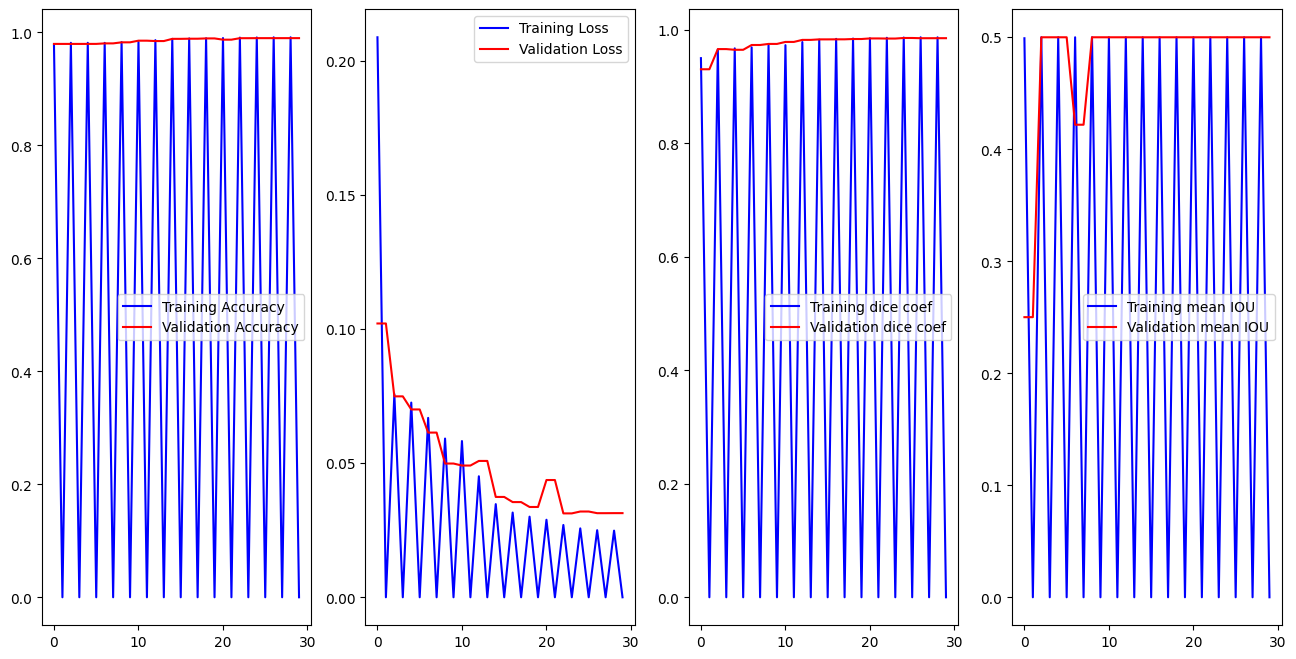

In [33]:
history = pd.read_csv('/content/training.log', sep=',', engine='python')

hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()